### Data Science Virtual Machine Audio Notebook 3

### Running Distributed Training on Batch A\I
This notebook describes how to set up and create a cluster with Azure Batch A\I for training a speech commands model using multiple worker VMs.  There are different methods of running distributed parallel training.  The method we will employ here is to run multiple *replicas*, i.e. copies of the same model-training operations that operate on different batches of data and average their results into the same model parameters.

### Setup
First, you'll need to set up a service principal to be able to charge Azure resources from Python code.  You can find instructions on Batch A\I recipes [page](https://github.com/Azure/BatchAI/tree/master/recipes).  Fill in TF_batch/credentials.json with the appropriate items from the setup process (e.g. subscription_id, aad_client_id, etc).

Next, create an Azure fileshare.  This can be done from [Azure Portal](http://portal.azure.com), adding a fileshare to a storage account (create one if needed).  Put the necessary details into TF_batch/credentials.json (e.g. storage_account.name, storage_account.key, storage_account.file_share).

After filling in credentials.json, you might need to restart the Jupyter kernel.

Place the training.h5, training.scaler, and validation.h5 data into a directory called data_speech_commands in your fileshare. This name is configurable later if you want to name it something else. Azure Storage Explorer is a handy GUI for viewing, uploading, and downloading files in Azure fileshares.   


In [1]:
# change notebook settings for wider screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Imports
Make sure you have azure-mgmt-batchai installed w/ pip

In [2]:
from datetime import datetime
import glob
import traceback

from TF_batch import cluster

### Constants
These are parameters for the rest of the notebook.

In [3]:
CONFIG_PATH = 'TF_batch/credentials.json'
NUM_WORKERS = 32
CLUSTER_NAME = 'audio'
# Use cluster.PRIORITY_LOW VMs for reduced cost.  Use cluster.PRIORITY_DEDICATED for more reliable uptime.
CLUSTER_PRIORITY = cluster.PRIORITY_DEDICATED

# Configuration of VM, e.g. STANDARD_NC6 (1x K80), STANDARD_NC12 (2x K80)
VM_SIZE = 'STANDARD_NC6'

# Remote execution
REMOTE_DATA_DIR = 'data_speech_commands'
REMOTE_SCRIPTS_DIR = 'audio_scripts'

### Creating a cluster
We've abstracted much of the details of creating a cluster into TF_batch/cluster.py. That file contains mostly calls to the Batch A\I API, examples of which can be found in their [recipes](https://github.com/Azure/BatchAI/tree/master/recipes). The getOrCreate function will reuse a cluster with the same name if it exists.

In [4]:
batch_cluster = cluster.TrainingCluster(cluster.Configuration(CONFIG_PATH), CLUSTER_NAME, NUM_WORKERS)
status = batch_cluster.getOrCreate(priority=CLUSTER_PRIORITY, vm_size=VM_SIZE)
if status.errors:
    print('Errors during cluster create, cleaning up and exiting.')
    print(', '.join([e.message for e in status.errors]))
       

Some optional commands for cluster management when needed.

In [23]:
batch_cluster.printClusterStatus()
# batch_cluster.delete()
batch_cluster.deleteAllJobs()

Cluster state = AllocationState.steady. Target= 32 Allocated = 32, NumIdle = 32, NumUnusable = 0, NumRunning = 0, NumPreparing = 0
*******************Deleting All Jobs
deleting job audio_train_17_01-50-27


### Preprocess Data to TF Examples
Keras doesn't seem to be set up super well as a distributed training library. Since we're interested in using our Keras model from DCASE, we find that a better way to run distributed training is to instantiate the Keras model inside a tf.contrib.learn.Estimator.

Before we can start training, we need to do a little preprocessing. The stardard way to pass data to the fit() function in TensorFlow is to set up streaming parsing of tf.Examples contained in TFRecord format. We have a script that does this for you, preprocess_speech_commands.  It reads in the HF5 from previous notebooks and outputs the examples to sharded TFRecord files.

In [ ]:
# First, preprocess the training and validation data.
cmd_line_args = batch_cluster.get_data_dir(data_dir=REMOTE_DATA_DIR)
job_name = 'preprocess_audio_data_' + datetime.utcnow().strftime('%d_%H-%M-%S')
batch_cluster.getOrLaunchJob(
    job_name,
    'TF_batch/remote/preprocess_speech_commands.py',
    additional_files=get_script_files(),
    remote_scripts_dir=REMOTE_SCRIPTS_DIR,
    num_job_workers=1,
    num_ps=0,
    master_args=cmd_line_args,
    worker_args=cmd_line_args,
    ps_args='')
    
print('Launch done, waiting for complete...')
batch_cluster.waitForJobDone(job_name)
print('Job done.')

### Launching a Training Job
We use a helper functions that cover the usual options of launching a job.  By default, every Python file in TF_batch/remote will be uploaded to the fileshare.

In [6]:
def get_script_files():
    """Return the python files to copy to the fileshare to be run."""
    return glob.glob('TF_batch/remote/*.py')
    
def launch(training_cluster, script, delete_job=True, delete_cluster=False, num_workers=None, num_ps=1,
           job_name=None, include_files=None, script_args=None, job_prep_cmd=None,
           container_name=None):
    """Launch a job and wait for it to finish."""

    try:
        files_to_include = include_files or get_script_files()
        job_name = job_name or (
            'audio_train_' + datetime.utcnow().strftime('%d_%H-%M-%S'))
        print('Launching job name: {0}'.format(job_name))
        args = script_args
        
        # Get location on mounted fileshare where data is
        mounted_data_dir = training_cluster.get_data_dir(
            data_dir=REMOTE_DATA_DIR)
        
        # Use a container just so we know what TF version we're using.
        cname = container_name or cluster.DEFAULT_IMAGE_GPU
        
        training_cluster.getOrLaunchJob(
            job_name, script, additional_files=files_to_include,
            remote_scripts_dir=REMOTE_SCRIPTS_DIR,
            num_job_workers=num_workers or NUM_WORKERS,
            num_ps=num_ps,
            master_args=training_cluster.makeCmdLine(
                'worker', mounted_data_dir, args),
            worker_args=training_cluster.makeCmdLine(
                'worker', mounted_data_dir, args),
            ps_args=training_cluster.makeCmdLine('ps', mounted_data_dir, args),
            job_prep_cmd=job_prep_cmd,
            vm_image_name=cname)
        print('Launch done, waiting for complete...')
        training_cluster.waitForJobDone(job_name)
        print('Job done.')
    except Exception as e:
        print(e)
        traceback.print_exc()
    finally:
        if delete_job:
            training_cluster.deleteJob(job_name)
        if delete_cluster:
            print('Deleting....')
            training_cluster.delete()
        return job_name

Launch the keras training script.  This might take a few minutes to start up if it's the first job run on the cluster (VMs need to be "prepared").



In [11]:
launch(
    batch_cluster,                    # defined in earlier cell
    'TF_batch/remote/train_estimator.py', # the script to run on each worker
    num_workers=4,                    # can run on up to NUM_WORKERS
    job_prep_cmd='pip install keras==2.1.2',  # we launch as a TF job in a TF container, needs keras
    script_args='--max_steps=2000 --batch_size=60'
)

Launching job name: audio_train_16_20-36-03
Uploading: ['TF_batch/remote\\data.py', 'TF_batch/remote\\dcase_estimator.py', 'TF_batch/remote\\dcase_keras.py', 'TF_batch/remote\\keras_estimator.py', 'TF_batch/remote\\multi_gpu.py', 'TF_batch/remote\\preprocess_speech_commands.py', 'TF_batch/remote\\speech_utils.py', 'TF_batch/remote\\tf_utils.py', 'TF_batch/remote\\train_estimator.py', 'TF_batch/remote\\train_keras.py']
Creating job...
Job created.
Launch done, waiting for complete...
State: running
job State = failed. ExitCode = 255 
FailureDetails:
ErrorCode:JobFailed
ErrorMessage:Job failed with non-zero exit code

Job done.
deleting job audio_train_16_20-36-03


'audio_train_16_20-36-03'

### Measure Scaling Performance
One question that presents itself is how many VMs should be used for a single training job?  We can attempt to answer this by measuring how long it takes training to reach a certain validation accuracy across different numbers of VMs.  

In [43]:
import urllib

def get_std(cluster_obj, job_name, worker=0, outtype='err'):
    files = cluster_obj.client.jobs.list_output_files(cluster_obj.config.resource_group, job_name,
                                                      cluster.trainingModels.JobsListOutputFilesOptions("stdOuterr"))
    url = None
    for f in files:
        if 'std{1}-wk-{0}.txt'.format(worker, outtype) == f.name:
            url = f.download_url
    response = urllib.request.urlopen(url)
    return response.read().decode("utf-8") 

def extract_result(cluster_obj, job_name):
    errtxt = get_std(batch_cluster, job_name, outtype='err')
    for l in errtxt.split('\n'):
        if 'Training time:' in l:
            words = l.split(' ')
            return float(words[words.index('time:') + 1])
    return None

def run_experiment(cluster_obj, target_accuracy=0.90, min_vms=1, max_vms=NUM_WORKERS):
    jobs = []
    errors = 0
    num_vms = min_vms
    results = []
    while num_vms <= max_vms:
        job_name = launch(
            batch_cluster,                    # defined in earlier cell
            'TF_batch/remote/train_estimator.py', # the script to run on each worker
            num_workers=num_vms,                    # can run on up to NUM_WORKERS
            num_ps=0 if num_vms == 1 else 1,
            delete_job=False,
            script_args="--max_steps=200000 --target_accuracy={0} --batch_size=60 --eval_every_n_steps=1000".format(
                target_accuracy),
            job_prep_cmd='pip install keras==2.1.2'  # we launch as a TF job in a TF container, needs keras

        )
        jobs.append(job_name)
        result = extract_result(cluster_obj, job_name)
        print('training time for {0} vms: {1}'.format(num_vms, result))
        
        if result is None:
            errors += 1
        else:
            results.append(result)
        num_vms = num_vms * 2
    
    print('Got {0} errors.'.format(errors))
    # clean up
    for j in jobs:
        cluster_obj.deleteJob(j)
        
    return results


In [50]:
results94 = run_experiment(batch_cluster, max_vms=8, target_accuracy=0.93)

Launching job name: audio_train_17_19-51-20
Uploading: ['TF_batch/remote\\data.py', 'TF_batch/remote\\dcase_estimator.py', 'TF_batch/remote\\dcase_keras.py', 'TF_batch/remote\\keras_estimator.py', 'TF_batch/remote\\multi_gpu.py', 'TF_batch/remote\\preprocess_speech_commands.py', 'TF_batch/remote\\speech_utils.py', 'TF_batch/remote\\tf_utils.py', 'TF_batch/remote\\train_estimator.py', 'TF_batch/remote\\train_keras.py']
Creating job...
Job created.
Launch done, waiting for complete...
State: running


Token expired or is invalid. Attempting to refresh.


job State = failed. ExitCode = 255 
FailureDetails:
ErrorCode:JobFailed
ErrorMessage:Job failed with non-zero exit code

Job done.
training time for 1 vms: 582.72903204
Launching job name: audio_train_17_20-01-50
Uploading: ['TF_batch/remote\\data.py', 'TF_batch/remote\\dcase_estimator.py', 'TF_batch/remote\\dcase_keras.py', 'TF_batch/remote\\keras_estimator.py', 'TF_batch/remote\\multi_gpu.py', 'TF_batch/remote\\preprocess_speech_commands.py', 'TF_batch/remote\\speech_utils.py', 'TF_batch/remote\\tf_utils.py', 'TF_batch/remote\\train_estimator.py', 'TF_batch/remote\\train_keras.py']
Creating job...
Job created.
Launch done, waiting for complete...
State: running
job State = failed. ExitCode = 255 
FailureDetails:
ErrorCode:JobFailed
ErrorMessage:Job failed with non-zero exit code

Job done.
training time for 2 vms: 338.418920994
Launching job name: audio_train_17_20-08-21
Uploading: ['TF_batch/remote\\data.py', 'TF_batch/remote\\dcase_estimator.py', 'TF_batch/remote\\dcase_keras.py', 

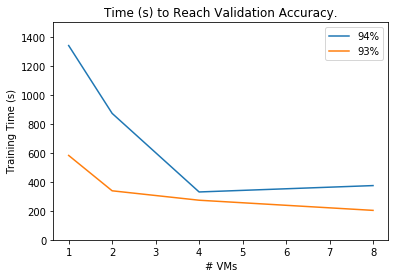

In [54]:

# results listed explicitly here, multiple runs were needed for different accuracies
saved_results94 = [1340, 872, 330, 374]
saved_results93 = [582, 338, 273, 203]

%matplotlib inline  
import matplotlib.pyplot as plt
    
plt.plot([1, 2, 4, 8], saved_results94, label='94%')
plt.plot([1, 2, 4, 8], saved_results93, label='93%')
plt.xlabel("# VMs")
plt.ylabel("Training Time (s)")
plt.ylim([0, 1500])
plt.title("Time (s) to Reach Validation Accuracy.")
plt.legend(loc=1)
plt.show()

We can see that when using a parameter server with a worker-replica model and asynchronous gradient updates, training time improves up to about 4-8 VMs.  After that, it generally doesn't converge because in asynchronous mode it becomes more likely that a worker will be out of date when they go to apply their parameter updates.  